processing /checkpoint/apratik/data_dec/0
[0, 90, 110, 128, 357]
[[-0.0, -0.0, -0.0], [1.7500028610229492, -0.6500000953674316, 0.19739713767948447], [3.162639856338501, 0.7626305818557739, 0.7853756247849332], [2.8374528884887695, 0.45932498574256897, 0.8960306080485514], [4.200003147125244, -3.5999958515167236, 2.356176992595576]]


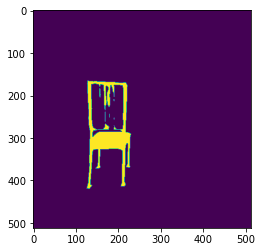

returning center .. [297 176]
512 512 (262144, 3)


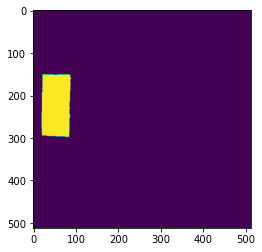

returning center .. [223  63]
512 512 (262144, 3)


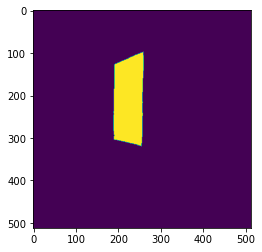

returning center .. [211 229]
512 512 (262144, 3)


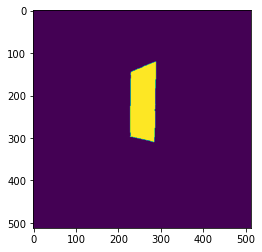

returning center .. [217 281]
512 512 (262144, 3)


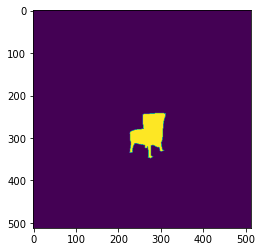

returning center .. [289 257]
512 512 (262144, 3)


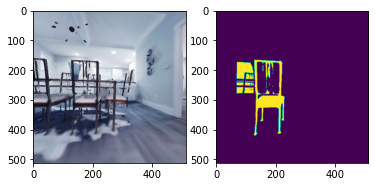

start pose [-0.0, -0.0, -0.0] 
spawn [0.18430092930793762, -1.374765157699585, 5.265953063964844] 
target [-0.3449999913573265, 0.42318750442937014, 1.1039999723434448]



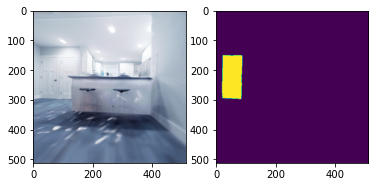

start pose [1.7500028610229492, -0.6500000953674316, 0.19739713767948447] 
spawn [0.8343010544776917, -1.374765157699585, 3.5159502029418945] 
target [-2.850204493200468, 1.0823672007769347, 4.866063712919718]



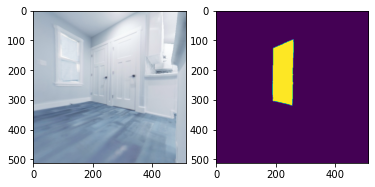

start pose [3.162639856338501, 0.7626305818557739, 0.7853756247849332] 
spawn [-0.5783296227455139, -1.374765157699585, 2.1033132076263428] 
target [-2.879393421229841, 1.0760156152769922, 4.8755763683040625]



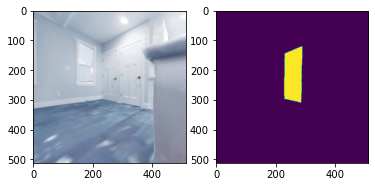

start pose [2.8374528884887695, 0.45932498574256897, 0.8960306080485514] 
spawn [-0.27502405643463135, -1.374765157699585, 2.428500175476074] 
target [-2.561275554366227, 1.0448437616229058, 4.884284181923221]



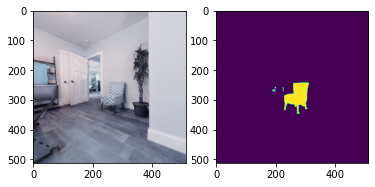

start pose [4.200003147125244, -3.5999958515167236, 2.356176992595576] 
spawn [3.784296751022339, -1.374765157699585, 1.0659500360488892] 
target [2.1206032661567282, 0.3313593607395887, 2.7321747139443104]

{0: {'spawn_pos': [0.18430092930793762, -1.374765157699585, 5.265953063964844], 'base_pos': [-0.0, -0.0, -0.0], 'target': [-0.3449999913573265, 0.42318750442937014, 1.1039999723434448]}, 1: {'spawn_pos': [0.8343010544776917, -1.374765157699585, 3.5159502029418945], 'base_pos': [1.7500028610229492, -0.6500000953674316, 0.19739713767948447], 'target': [-2.850204493200468, 1.0823672007769347, 4.866063712919718]}, 2: {'spawn_pos': [-0.5783296227455139, -1.374765157699585, 2.1033132076263428], 'base_pos': [3.162639856338501, 0.7626305818557739, 0.7853756247849332], 'target': [-2.879393421229841, 1.0760156152769922, 4.8755763683040625]}, 3: {'spawn_pos': [-0.27502405643463135, -1.374765157699585, 2.428500175476074], 'base_pos': [2.8374528884887695, 0.45932498574256897, 0.8960306080485514

In [15]:
# get candidate image_ids, spawn location, target xyz
from candidates import SampleGoodCandidates
from droidlet.lowlevel.robot_mover_utils import transform_pose
from droidlet.lowlevel.robot_coordinate_utils import base_canonical_coords_to_pyrobot_coords, xyz_pyrobot_to_canonical_coords
from droidlet.perception.robot import convert_depth_to_pcd, compute_uvone

baseline_root = '/checkpoint/apratik/data_dec/'

import os 
import glob
import json
import matplotlib.pyplot as plt 
import cv2
import numpy as np
import copy

instance_ids = [243,404,196,133,166,170,172]
fx, fy = 256, 256
cx, cy = 256, 256
intrinsic_mat = np.array([[  fx, 0., cx],
                            [  0., fy, cy],
                            [  0., 0., 1.]])
# rotation from pyrobot to canonical coordinates (https://github.com/facebookresearch/fairo/blob/main/agents/locobot/coordinates.MD)
rot = np.array([[0.0, 0.0, 1.0], [-1.0, 0.0, 0.0], [0.0, -1.0, 0.0]])
CAMERA_HEIGHT = 0.6
trans = np.array([0, 0, CAMERA_HEIGHT])
uv_one_in_cam = compute_uvone(512,512)

def visualize_instances(traj_path, img_ids, inst_ids):
    for img_indx in img_ids:
        src_img = cv2.imread(os.path.join(traj_path, "rgb/{:05d}.jpg".format(img_indx)))
        # src_depth = np.load(os.path.join(root, "depth/{:05d}.npy".format(img_indx)))
        src_label = np.load(os.path.join(traj_path, "seg/{:05d}.npy".format(img_indx)))
        all_label = np.zeros_like(src_label).astype(np.int32)
        for x in instance_ids:
            all_label = np.bitwise_or(src_label == x, all_label)
        
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(src_img)
        ax2.imshow(all_label)
        plt.show()

def is_annot_validfn_inst(annot):
    if annot not in instance_ids:
        return False
    return True

def get_center(mask):
    
    plt.imshow(mask)
    plt.show()
    m = np.argwhere(mask == 1)
    l = len(m)
    c = m[int(l/2)]
    print(f'returning center .. {c}')
    return c

def get_center_of_larger_mask(seg, instance_ids):
    larea = 0
    lm = instance_ids[0]
    for x in instance_ids:
        bm = (seg == x)
        if bm.sum() > larea:
            larea = bm.sum()
            lm = x
            
    if larea == 0:
        return None
    # get center of x 
    return get_center(seg == lm)

def get_target(traj_path, img_indx, instance_ids, base_pos):
    src_depth = np.load(os.path.join(traj_path, "depth/{:05d}.npy".format(img_indx)))
    src_label = np.load(os.path.join(traj_path, "seg/{:05d}.npy".format(img_indx)))
    
    # pick the larger mask, get centroid for that 
    c = get_center_of_larger_mask(src_label, instance_ids)
    if c is None:
        return None
    
    # get xyz for 
    
    height, width = src_depth.shape
    uv_one_in_cam, intrinsic_mat, rot, trans = compute_uvone(height, width)
    pts = convert_depth_to_pcd(src_depth, base_pos, uv_one_in_cam, rot, trans)
    print(height, width, pts.shape)
    pts = pts.reshape((height, width, 3))
    
    xyz_pyrobot = pts[c[0],c[1]]
    return xyz_pyrobot_to_canonical_coords(xyz_pyrobot).tolist()
    
def habitat_base_pos(xyt):
    # np.asarray([0.18430093, -1.3747652 ,  5.265953])
    x_standard = xyt[0] + 0.18430093
    z_standard = xyt[1] -1.3747652 
    return [x_standard, z_standard, xyt[2]+5.265953]

    
def canonical_base_pos(xyt):
    x_standard = -xyt[1]
    z_standard = xyt[0]
    return [x_standard, z_standard, xyt[2]]

    
def process(traj_path):
    # get candidates
    # s = SampleGoodCandidates(traj_path, is_annot_validfn_inst)
    # src_img_ids = s.get_n_candidates(5, good=True, evenly_spaced=True)
    src_img_ids = [0, 90, 110, 128, 357]
    print(src_img_ids)
    
    reexplore_task_data = {}
    
    base_poses = []
    base_poses_hab = []
    if os.path.isfile(os.path.join(traj_path, 'data_hab.json')):
        with open(os.path.join(traj_path, 'data_hab.json'), 'r') as f:
            data = json.load(f)
            for x in src_img_ids:
                base_poses_hab.append(data[str(x)])
                
    # get spawn location
    if os.path.isfile(os.path.join(traj_path, 'data.json')):
        with open(os.path.join(traj_path, 'data.json'), 'r') as f:
            data = json.load(f)
            for x in src_img_ids:
                base_poses.append(data[str(x)])
                
    print(base_poses)
    
    # Visualize rgb
    # visualize_instances(traj_path, src_img_ids, instance_ids)
            
    
    # get target xyz
    target_xyz = []
    for i in range(len(src_img_ids)):
        target_xyz.append(get_target(traj_path, src_img_ids[i], instance_ids, base_poses[i]))
    
    # base_poses = [habitat_base_pos(x) for x in base_poses]
    for i in range(len(src_img_ids)):
        visualize_instances(traj_path, [src_img_ids[i]], instance_ids)
        print(f'start pose {base_poses[i]} \nspawn {base_poses_hab[i]} \ntarget {target_xyz[i]}\n')
        reexplore_task_data[i] = {
            'spawn_pos': base_poses_hab[i],
            'base_pos': base_poses[i],
            'target': target_xyz[i]
        }
        
    print(reexplore_task_data)
    with open(os.path.join(traj_path, 'reexplore_data.json'), 'w') as f:
        json.dump(reexplore_task_data, f)
        

for x in glob.glob(baseline_root + '*'):
    if x.split('/')[-1].isdigit():
        print(f'processing {x}')
        process(x)
        break